# 15. 프로젝트: 한국어 데이터로 챗봇 만들기
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시킨다.

## 이론 정리
- AIFFEL 과정에서 배운 내용과 ['딥러닝을 이용한 자연어 처리 입문'](https://wikidocs.net/31379)을 참고하여 정리하였다. 

## 번역기와 챗봇
번역기를 만들 때 사용하는 대표적인 모델은 '인코더와 디코더'의 아키텍처로 구성되어 있다. 인코더에 입력 문장이 들어가고, 디코더는 이에 상응하는 출력 문장을 생성한다. 즉 입력문장과 출력 문장 2가지 병렬 구조로 구성된 데이터셋을 훈련하여 새로운 문장이 들어왔을 때 그에 상응하는 출력문장을 생성할 수 있다. 이와 같은 구조를 이용하여 챗봇도 만들 수 있다. 

#### 훈련 데이터셋의 구성(질문-답변)
- 입력문장: '1지망 학교 떨어졌어'
- 출력문장: '위로해 드립니다.'    
병렬적으로 구성된 데이터셋이다. 질문에 대해서 대답을 하도록 구성된 데이터셋을 인코더와 디코더 구조로 학습하여 주어진 질문에 답할 수 있는 챗봇을 만들 수 있다. 

## 트랜스포머의 주요 하이퍼파라미터
- $d_{model}$: 트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기, 임베딩 벡터의 차원. 이 차원은 여러 층의 인코더와 디코더로 값을 보낼 때도 계속 유지된다. 논문에서는 512이다. 
- num\_layers: 트랜스포머에서의 인코더와 디코더의 층의 개수, 논문에서는 6개의 층으로 구성되었다. 
- num\_heads: 병렬 어텐션의 개수, 논문에서는 8개이다. 
- $d_{ff}$(units): 트랜스포머 내부에 존재하는 피드 포워드 신경망의 은닉층의 크기이며, 논문에서는 2048이다.

## 트랜스포머의 인코더와 디코더
트랜스포머 역시 인코더와 디코더의 구성을 가지기 때문에 입력 문장을 넣으면 출력 문장을 생성한다. 그러나 기존의 RNN을 사용한 모델과 달리 트랜스포머는 RNN을 없애고 Attention 기법만을 사용하고, 인코더와 디코더를 여러 개 쌓은 구조로 되어 있다. 

![](https://images.velog.io/images/guide333/post/6a4a5e17-5127-451f-a199-8028c2f771cd/Screenshot%20from%202021-03-04%2011-06-12.png)

### Positional Encoding
아래의 그림은 트랜스포머의 인코더와 디코더 구조를 간단히 그림으로 표현한 것이다. 그림의 Encoders와 Decoders는 6개의 인코더와 디코더를 의미한다. 먼저 단어를 원-핫 벡터로 만든 후, 차원을 줄이기 위해서 embedding layer를 지나간다. 여기까지는 RNN과 같은 방식이다. 그러나 인코더와 디코더에 단어 벡터를 넣기 전 Positional Encoding이라는 단계를 하나 더 거친다. 

![](https://images.velog.io/images/guide333/post/541a9083-c5e3-4eb2-ac2f-ce805dfb63a1/Screenshot%20from%202021-03-04%2011-11-03.png)

순차적으로 단어를 집어 넣는 RNN과 달리 트랜스포머는 한꺼번에 입력 문장을 넣기 때문에 단어의 위치 정보(어순)를 알려주기 위해서 Positional Encoding을 해주어야만 한다. 아래의 그림과 같이 positional encoding과 embedding vector를 각 엘레먼트 별로(element-wise) 더해준다.

![](https://images.velog.io/images/guide333/post/be37636e-6cda-40c5-95dc-bc5bc89c3136/Screenshot%20from%202021-03-04%2011-11-08.png)

트랜스포머는 사인함수와 코사인함수의 값을 임베딩 벡터에 더해주어 단어의 순서 정보를 더해준다. 임베딩 벡터의 각 차원의 인덱스가 짝수인 경우에는 사인함수의 값을, 홀수인 경우에는 코사인 함수의 값을 사용한다. 

![](https://images.velog.io/images/guide333/post/66af2db8-7bdf-4295-bf70-975f6864ba80/Screenshot%20from%202021-03-04%2011-11-17.png)

- $d_{model}$: 임베딩 벡터의 차원
- pos: 입력 문장에서의 임베딩 벡터의 위치
- i: 임베딩 벡터 내의 차원의 인덱스
  
  Q. 최대 문장의 길이가 50, 워드 임베딩 차원을 512로 하는 포지셔널 인코딩 행렬의 모습은 어떻게 되는가? 또한 포지셔널 인코딩 레이어를 사용하여 표현해 보아라. 
  50x512, positional_encoding(50, 512)
  
### Attention
  트랜스포머에서 가장 핵심적인 개념은 Attention이며, 어텐션은 단어들 간 유사도를 구하는 매커니즘이다. 그리고 Attention에서 핵심적인 것은 Query, Key, Value이다. 우선 쿼리, 키, 밸류는 입력 문장의 모든 단어들의 벡터라는 사실을 잊지 말아야 한다.
  
쿼리는 말 그대로 질문을 하는 것이다. 즉 알아보고자 하는 단어가 쿼리이고 문장의 모든 단어가 키이다. 알고자 하는 단어(쿼리)가 문장의 모든 단어(키들)와 얼마만큼의 유사도를 가지고 있는지를 구한다. 여기서 구한 쿼리와 키와의 유사도를 키와 매핑(mapping)되어 있는 값(밸류)에 반영한다. 유사도가 반영된 값을 모두 하나로 더한 것이 어텐션 값(Attention Value)이다. 
  
  ![](https://images.velog.io/images/guide333/post/67ec148c-dd7f-47d1-821f-0090127a361a/Screenshot%20from%202021-03-04%2011-51-25.png)
  
트랜스포머에서는 아래와 같은 3가지의 어텐션을 사용한다. 

![](https://images.velog.io/images/guide333/post/7a2ddc3b-9126-49fd-bbc3-6068dcc86836/Screenshot%20from%202021-03-04%2011-52-37.png)

인코더 셀프 어텐션은 인코더에서, 디코더 셀프 어텐션과 인코더-디코더 어텐션은 디코더에서 이루어진다. 

- 인코더 셀프 어텐션: 인코더의 입력으로 들어간 문장 내 단어들의 유사도를 구한다.
- 디코더 셀프 어텐션: 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어와의 유사도를 구한다. (뒤의 단어와의 유사도를 알지 못하도록 마스크를 씌워준다.)
- 인코더-디코더 어텐션: 인코더에 입력된 단어들과 디코더의 단어 간의 유사도를 구한다. 

### Q, K, V 구하기 
Q, K, V는 아래의 그림과 같이 각 단어 벡터에 가중치 행렬을 곱해 구할 수 있다. 아래의 그림은 간략하게 그렸지만 논문에서는 $d_{model}=512$ 차원을 가진 각 단어 벡터들이 64차원의 Q, K, V 벡터로 변환되었다. 여기서 64는 $d_{model}=512$을 num\_heads=8로 나눈 것이다. (num_heads는 뒤에서 나올 Multi Head Attention에서 나올 하이퍼파라미터이다.)

- Q, K, V의 차원: $d_{model}$/ num\_heads 
- 가중치 행렬의 크기: $d_{model}$ x $d_{model}$/num\_heads
  (가중치 행렬은 훈련 과정 중 학습된다.)
![](https://images.velog.io/images/guide333/post/d2f4c481-aa5e-4f05-af4d-1d14ee9fe472/Screenshot%20from%202021-03-09%2020-39-33.png)

### Scaled Dot Product Attention
어텐션 값을 구하는 수식은 아래와 같다. 

![](https://images.velog.io/images/guide333/post/deb3aafd-c292-496b-b685-ff4f7f0ed6bc/Screenshot%20from%202021-03-04%2011-57-46.png)

- Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.
- 벡터의 내적(dot product)은 벡터의 유사도를 의미한다.
- 값의 크기를 조절하는 스케일링을 한다. 

수식을 그림으로 표현하면 아래와 같다. 

![](https://images.velog.io/images/guide333/post/1643056d-18d8-4671-bf1d-99a6097317d0/Screenshot%20from%202021-03-04%2012-00-19.png)

초록색 행렬은 각 단어 벡터의 유사도가 모두 기록된 __유사도 행렬__($QK^T$)이다. 이 유사도 값을 스케일링해주려고 행렬 전체를 특정 값($\sqrt{d_k}$)으로 나눠준다. (논문에서 $d_k=d_{model}$/num_heads=64이므로 $\sqrt{d_k}$는 8이다.) 그 후 소프트맥스 함수를 사용하여 어텐션 분포를 구하고, 각 어텐션 분포에서 나온 값에 문장 행렬 V를 곱하면 어텐션 값이 나온다. (노드에서는 정규화를 해주려고 소프트맥스 함수를 사용한다고 나온다.)

위의 수식은 내적을 통해 단어 벡터 같 유사도를 구한 후 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 해서 스케일드 닷 프로덕트 어텐션이라고 한다. 

- 행렬의 크기 
1. $d_k$: Q, K 벡터의 크기 -> Q, K 행렬의 크기: (seq\_len, $d_k$), V 행렬의 크기: (seq_len, $d_v$) 
2. $W^Q, W^K$의 크기: ($d_{model}, d_k$), $W^V$의 크기: ($d_{model}, d_v$)(문장행렬과 Q, K, V행렬의 크기로부터 추정)
3. $d_k=d_v=d_{model}$/num\_heads이므로 어텐션 값 행렬 a의 크기는 (seq\_len, $d_v$)이다. 

### Multi-Head Attention
어텐션을 병렬로 수행하는 것을 멀티 헤드 어텐션이라고 한다. 트랜스포머는 입력된 문장 행렬을 num\_heads의 수만큼 쪼개 어텐션을 수행하고 어텐션의 값 행렬 num\_heads개를 하나로 연결(concatenate)한다. 연결된 어텐션 헤드 행렬의 크기는 (seq\_len, $d_{model}$)이다.

![](https://images.velog.io/images/guide333/post/50ac269d-fd1f-4d9c-ac47-3d60626cc077/Screenshot%20from%202021-03-04%2012-07-00.png)

병렬로 수행되는 어텐션은 서로 다른 시각에서의 셀프 어텐션 결과를 얻기 때문에 각각 다른 관점에서의 정보를 얻을 수 있어서 효과가 더 좋다. 
![](https://images.velog.io/images/guide333/post/145034e0-9d28-49b0-931c-41ce470aeb21/Screenshot%20from%202021-03-09%2021-08-10.png)

어텐션 헤드를 모두 연결한 행렬에 가중치 행렬 $W^O$를 곱해 나온 결과 행렬이 멀티 헤드 어텐션의 결과물이며, 이 행렬의 크기는 (seq\_len, $d_{model}$)이다. 

여기서 가중치 행렬을 곱하는 것을 구현 상에서는 입력을 밀집층(Dense layer)를 지나게 하여 구현한다. 

### Masking
#### 1. Padding Masking
 패딩토큰을 이용한 마스킹을 패딩 마스킹이라고 한다. 자연어 처리에서 정해준 길이보다 짧은 문장에 숫자 0을 채워서 문장의 길이를 맞춰주는 전처리 작업을 한다. 여기서 숫자 0은 실제 의미가 있는 단어가 아니므로 어텐션 등과 같은 연산에서 제외하기 위해 패딩 마스킹을 한다.
 
scaled_dot_product_attention() 함수에서 ```logits += (mask * -1e9)```이 패딩 마스킹의 역할을 한다. 즉 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수값을 넣어준다. 소프트맥스 함수를 지나면 해당 위치의 값은 0에 가까운 값이 되어 패딩 토큰이 단어 간 유사도를 구하는데 반영되지 않는다. 

![](https://images.velog.io/images/guide333/post/fba8e8fe-b191-4654-b40c-89ae178cc057/Screenshot%20from%202021-03-09%2021-18-27.png)

#### 2. Look-ahead masking(다음 단어 가리기)
룩어헤드 마스킹은 디코더의 셀프 어텐션에서 사용된다. 인코더와 달리 디코더에서는 뒤의 단어를 미리 알게 되면 다음 단어를 예측하는 훈련을 할 수 없기 때문에 자신보다 다음에 나올 단어를 참고하지 않도록 가려준다. 즉 쿼리 단어 뒤에 나오는 키 단어들에 대해서 마스킹하여 이전 단어들과의 유사도만 구하게 한다. 아래의 그림에서 빨간색 부분이 마스킹한 부분이다.
![](https://images.velog.io/images/guide333/post/0d992e3a-da5a-4516-8bcb-498e203ae779/Screenshot%20from%202021-03-09%2022-45-55.png)

룩어헤드 마스크에는 패딩 마스크를 포함하도록 구현한다. 

### Position-wise FFNN 포지션-와이즈 피드 포워드 신경망
포지션 와이즈 FFNN(Fully-connected FFNN)의 수식과 식을 그림으로 표현한 것은 아래와 같다. 

$$FFNN(x) = MAX(0, xW_1+b_1)W_2 + b_2$$

![](https://images.velog.io/images/guide333/post/5fc68984-22cb-4556-9835-9c8d281ee7ae/Screenshot%20from%202021-03-09%2021-31-15.png)

- x: 멀티 헤드 어텐션의 결과로 나온 (seq\_len, $d_{model}$)의 크기를 가지는 행렬
- 가중치 행렬 $W_1$: ($d_{model}, d_{ff}$)의 크기를 가진다.
- 가중치 행렬 $W_2$: ($d_{ff}, d_{model}$)의 크기를 가진다. ($d_{ff}$는 은닉층의 크기)

매개변수 $W_1, b_1, W_2, b_2$은 하나의 인코더 층에서는 동일하나 인코더 층마다는 다른 값을 가진다. 

![](https://images.velog.io/images/guide333/post/5cc9e463-89b1-4e4e-ae9d-22e773682c32/Screenshot%20from%202021-03-09%2021-33-34.png)

### Residual connection 잔차 연결, Layer Normalization 층 정규화

![](https://images.velog.io/images/guide333/post/daa47032-4692-44ce-ade1-90f263c86bb0/Screenshot%20from%202021-03-09%2021-35-33.png)

#### 1. 잔차 연결
![](https://images.velog.io/images/guide333/post/380a32c4-dff1-4b41-a4c6-73085fe4fafc/Screenshot%20from%202021-03-09%2021-36-17.png)

함수 $F(x)$는 트랜스포머에서의 서브층을 의미한다. 잔차연결은 서브층의 입력과 출력을 더하는 것이다. 만약 서브층이 멀티 헤드 어텐션이면 잔차 연결 연산은 아래와 같다.  

![](https://images.velog.io/images/guide333/post/0ebdf378-c152-4a47-81f8-6fc071960957/Screenshot%20from%202021-03-09%2021-37-34.png)

#### 2. 층 정규화
$$LN = LayerNorm(x + Sublayer(x))$$ 

층 정규화는 __텐서의 마지막 차원__ 에 대해 평균과 분산을 구한 값으로 정규화하여 학습을 돕는다. 텐서의 마지막 차원은 $d_{model}$ 차원이며, 아래 그림은 $d_{model}$ 차원의 방향을 화살표로 표현하였다. 출력의 크기는 (seq\_len, $d_{model}$)이다. 화살표 방향으로 평균과 분산을 구하고, 정규화를 해준다. 층 정규화를 한 후에 벡터 $x_i$는 $ln_i$라는 벡터로 정규화된다. 

![](https://images.velog.io/images/guide333/post/7a50b2c8-8c78-4287-bfab-3415678cfff1/Screenshot%20from%202021-03-09%2022-27-57.png)

$$ln_i=LayerNorm(x_i)$$

층 정규화는 2가지 과정으로 이루어진다. 

1. 평균과 분산을 통해 벡터 $x_i$를 정규화한다.
$$\hat x_{i,k} = \frac {x_{i,k}-\mu_i}{\sqrt{{\sigma_i}^2 + \epsilon}}$$ 
(여기서 $\epsilon$은 분모가 0이 되는 것을 방지하는 값)

2. 감마와 베타라는 벡터를 준비해 아래와 같이 정규화를 해준다. (감마와 베타의 초기값은 각각 1과 0이다.)
![](https://images.velog.io/images/guide333/post/2fee9051-c08b-406b-9d3e-63eb0cb25e81/Screenshot%20from%202021-03-09%2022-34-18.png)
$$ln_i = \gamma \hat x_i + \beta = LayerNorm(x_i)$$  ($\gamma, \beta$는 학습 가능한 파라미터)

### 디코더에서의 어텐션
디코더에는 두 개의 멀티 헤드 어텐션이 들어간다. 첫번째 서브층은 mask의 인자값으로 look_ahead_mask가 들어가고, 두번째 서브층은 mask의 인자값으로 padding_mask가 들어간다. 

## 트랜스포머 구현
인코더와 디코더를 각각 구현하고, 인코더와 디코더를 각각 원하는 개수만큼 쌓아준다. 인코더를 먼저 쌓고 마지막 인코더에서의 출력값을 디코더로 전달해준다. 디코더를 쌓은 후 마지막에 다중 클래스 분류 문제를 풀 수 있도록 vocab_size만큼의 뉴련을 가지는 신경망을 추가한다. 

## 트랜스포머 하이퍼파라미터 
- 단어 집합의 크기 vocab\_size
- 룩업 테이블을 수행할 임베딩 테이블과 포지셔널 인코딩의 행렬의 행의 크기 num\_layers
- 포지션 와이즈 피드 포워드 신경망의 은닉층 $d_{ff}$
- 인코더와 디코더의 입/출력 차원 $d_{model}$
- 멀티-헤드 어텐션의 헤드 수 num\_heads

## 손실함수
다중 클래스 분류 문제이므로 크로스 엔트로피 함수를 손실함수로 사용한다.

## 학습률 learning rate
학습 경과에 따라 학습률이 변하도록 설계하였다. 아래는 공식이며 warmup\_step은 4,000이다. 

$ Irate = d_{model}^{-0.5} x min(step_min^{-0.5}, step_num x warmup_steps^{-1.5}$

위의 수식은 $step\_num^{−0.5}$에 비례하는 부분과 $step\_num$에 비례하는 부분 중 작은 쪽을 택하도록 되어 있어서 학습 초기에는 learning_rate가 $step\_num$에 비례해서 증가하다가 이후로는 감소한다. 

이처럼 학습 초기에 학습률을 급격히 높였다가 이후 학습이 진행되면서 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하는 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다. 

## 순서
1. 데이터 수집하기
2. 데이터 전처리하기
3. SubwordTextEncoder 사용하기
4. 모델 구성하기
5. 모델 평가하기

### Step 1. 데이터 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용한다.

```python
$ wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
```

In [1]:
# 필요한 라이브러리 불러오기 
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import time


Duplicate key in file PosixPath('/home/aiffel-dj44/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 253 ('font.family:  sans-serif')


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv", filename="ChatBotData.csv")
chatbot_data = pd.read_csv('ChatBotData.csv')
chatbot_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
print('챗봇 샘플의 개수: {}'.format(len(chatbot_data)))

챗봇 샘플의 개수: 11823


질문과 답변의 쌍으로 이루어진 데이터셋이고, 챗봇 샘플의 개수는 11,823개이다.

In [4]:
print(chatbot_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [5]:
print(chatbot_data['Q'])

0                         12시 땡!
1                    1지망 학교 떨어졌어
2                   3박4일 놀러가고 싶다
3                3박4일 정도 놀러가고 싶다
4                        PPL 심하네
                  ...           
11818             훔쳐보는 것도 눈치 보임.
11819             훔쳐보는 것도 눈치 보임.
11820                흑기사 해주는 짝남.
11821    힘든 연애 좋은 연애라는게 무슨 차이일까?
11822                 힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object


In [6]:
print(chatbot_data['A'])

0                      하루가 또 가네요.
1                       위로해 드립니다.
2                     여행은 언제나 좋죠.
3                     여행은 언제나 좋죠.
4                      눈살이 찌푸려지죠.
                   ...           
11818          티가 나니까 눈치가 보이는 거죠!
11819               훔쳐보는 거 티나나봐요.
11820                      설렜겠어요.
11821    잘 헤어질 수 있는 사이 여부인 거 같아요.
11822          도피성 결혼은 하지 않길 바라요.
Name: A, Length: 11823, dtype: object


### Step 2. 데이터 전처리하기
정규표현식을 이용하여 구두점을 단어들과 분리시켜 단어와 구두점 사이에 공백을 추가한다. 이로써 단어를 토크나이징하는 과정에서 구두점과 붙어 있는 단어를 하나의 단어로 인식하는 것을 방지할 수 있다.

영어 데이터와 다르게 한국어 데이터는 대문자, 소문자 개념이 없으므로 노드에서의 소문자 변환 부분은 제거하였다. 단어와 구두점 사이에 거리를 만들고 문장 중간이나 양 옆에 빈 곳이 있다면 다 없애 버렸다.

In [7]:
questions = []
for sentence in chatbot_data['Q']:
    # 단어와 구두점 사이에 거리를 만든다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [8]:
answers = []
for sentence in chatbot_data['A']:
    # 단어와 구두점 사이에 거리를 만든다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [9]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [10]:
print('전체 샘플수 :', len(questions))
print('전체 샘플수 :', len(answers))

전체 샘플수 : 11823
전체 샘플수 : 11823


데이터를 학습데이터와 평가데이터로 나누어 결과를 확인한다. 

In [11]:
from sklearn.model_selection import train_test_split

questions, test_Q, answers, test_A = train_test_split(questions, 
                                                      answers, 
                                                      test_size=0.1,  
                                                      shuffle=True)

print("questions:", len(questions)) 
print("answers:", len(answers))
print("test_Q:", len(test_Q)) 
print("test_A:", len(test_A))

questions: 10640
answers: 10640
test_Q: 1183
test_A: 1183


### Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 하지만 여기서는 형태소 분석기가 아닌 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용한다. 그 과정은 다음과 같다. 

1. TensorFlow Datasets __SubwordTextEncoder를 토크나이저__ 로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 __정수로 인코딩__ 한다.
2. 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
3. 최대 길이 __MAX_LENGTH__ 인 40을 넘는 문장들은 필터링한다.
4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩한다.

#### 1. 단어장 만들기
각 단어에 고유한 정수 인덱스를 부여하기 위해 단어장을 만든다.

In [12]:
# 질문과 답변 데이터셋에 대한 vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [13]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size+1]

In [14]:
print('START_TOKEN의 번호 :', [tokenizer.vocab_size])
print('END_TOKEN의 번호 :', [tokenizer.vocab_size+1])

START_TOKEN의 번호 : [7600]
END_TOKEN의 번호 : [7601]


현재 단어장의 크기가 7,599이라는 의미이다. 2개의 토큰을 추가했으므로 단어장의 크기도 +2임을 명시한다. 

In [15]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

7602


#### 2. 각 단어를 고유한 정수로 인코딩 & 패딩
tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

In [16]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업 수행, 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [107, 168, 2808, 2478, 660]
정수 인코딩 후의 21번째 답변 샘플: [6, 6710, 10, 43, 1]


In [17]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

40


In [18]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기: {}'. format(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(questions)))

단어장의 크기: 7602
필터링 후의 질문 샘플 개수: 10640
필터링 후의 답변 샘플 개수: 10640


In [19]:
print(questions[0])

[7600  425   13  112   13  777   13  937 7601    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [20]:
print(answers[0])

[7600  359 1667   34  261    1 7601    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


### Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현한다. 

- 미리 구현해야 할 레이어
1. Positional Encoding
2. Attention(scaled dot product attention)
3. Multi-head Attention
4. Padding masking
5. Look ahead masking

- 인코더
1. Input
2. Padding mask
3. Multi-head Attention(self-attention)
4. Dropout + Residual connection + Layer Normalization
5. Position-wise FFNN
6. Dropout + Residual connection + Layer Normalization

- 인코더 쌓기

- 디코더
1. Look-ahead mask
2. Padding mask
3. Multi-head Attention(masked self attention)
4. Residual connection + Layer Normalization
5. Multi-head Attention(encoder-decoder attention)
6. Dropout + Residual connection + Layer Normalization
7. Position-wise FFNN
8. Dropout + Residual connection + Layer Normalization

- 디코더 쌓기

- 트랜스포머 구현

In [21]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- tf.pow(x, y) : Given a tensor x and a tensor y, this operation computes $x^y$ for corresponding elements in x and y.
- tf.dtypes.cast(x, tf.int32): The operation casts x (in case of Tensor) or x.values (in case of SparseTensor or IndexedSlices) to dtype.
- tf.range(limit, delta=1, dtype=None, name='range')      
tf.range(start, limit, delta=1, dtype=None, name='range')      
Creates a sequence of numbers that begins at start and extends by increments of delta up to but not including limit.

The dtype of the resulting tensor is inferred from the inputs unless it is provided explicitly.

Like the Python builtin range, start defaults to 0, so that range(n) = range(0, n).

```python
start = 3
limit = 18
delta = 3
tf.range(start, limit, delta)

# <tf.Tensor: shape=(5, ), dtype=int32, numpy=array([3,6,9,12,15], dtype=int32)>
```

In [22]:
def scaled_dot_product_attention(query, key, value, mask):
  """어텐션 가중치를 계산. """
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers(가중치 행렬곱)
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer(가중치 행렬곱)
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [24]:
# 패딩 마스킹 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [25]:
# 룩어헤드 마스킹 함수 구현
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

- tf.linalg.band_part(
    input, num_lower, num_upper, name=None
)
: Copy a tensor setting everything outside a central band in each innermost matrix to zero.

- t f.ones(
    shape, dtype=tf.dtypes.float32, name=None
)
: Creates a tensor with all elements set to one (1).

- tf.math.maximum(
    x, y, name=None
):
Returns the max of x and y (i.e. x > y ? x : y) element-wise.

In [26]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 
          'key': inputs, 
          'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층): 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [27]:
# 인코더 쌓기
def encoder(vocab_size, 
            num_layers, 
            units,
            d_model, 
            num_heads, 
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  # 포지셔널 인코딩 
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  # 드롭아웃
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model, 
        num_heads=num_heads,
        dropout=dropout, 
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [28]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브레이어)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브레이어)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 
          'key': inputs, 
          'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 
          'key': enc_outputs, 
          'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [29]:
# 디코더 쌓기
def decoder(vocab_size, 
            num_layers, 
            units,
            d_model, 
            num_heads, 
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    
  # 패딩 마스크  
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩 
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [30]:
# 교사 강요
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
# 트랜스포머 구현
def transformer(vocab_size, 
                num_layers, 
                units,
                d_model, 
                num_heads, 
                dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, 
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(
      vocab_size=vocab_size, 
      num_layers=num_layers, 
      units=units,
      d_model=d_model, 
      num_heads=num_heads, 
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(
      vocab_size=vocab_size, 
      num_layers=num_layers, 
      units=units,
      d_model=d_model, 
      num_heads=num_heads, 
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층(다음 단어 예측을 위한 출력층0)
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [32]:
# 모델 생성
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 3 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3527424     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [33]:
# 손실함수
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [34]:
# 학습률
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

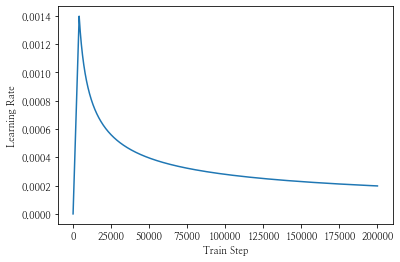

In [35]:
# 학습률 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [36]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [37]:
# 훈련
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
167/167 [==============================] - 12s 70ms/step - loss: 1.4670 - accuracy: 0.0204
Epoch 2/20
167/167 [==============================] - 12s 69ms/step - loss: 1.2221 - accuracy: 0.0469
Epoch 3/20
167/167 [==============================] - 11s 69ms/step - loss: 1.0412 - accuracy: 0.0502
Epoch 4/20
167/167 [==============================] - 12s 70ms/step - loss: 0.9636 - accuracy: 0.0532
Epoch 5/20
167/167 [==============================] - 11s 68ms/step - loss: 0.9123 - accuracy: 0.0561
Epoch 6/20
167/167 [==============================] - 11s 68ms/step - loss: 0.8631 - accuracy: 0.0588
Epoch 7/20
167/167 [==============================] - 12s 70ms/step - loss: 0.8086 - accuracy: 0.0627
Epoch 8/20
167/167 [==============================] - 11s 68ms/step - loss: 0.7483 - accuracy: 0.0682
Epoch 9/20
167/167 [==============================] - 12s 69ms/step - loss: 0.6817 - accuracy: 0.0754
Epoch 10/20
167/167 [==============================] - 11s 68ms/step - loss: 0.611

Loss가 점차 떨어지는 것을 볼 수 있다.

### Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만든다.

예측 단계는 다음의 과정을 거친다.
1. 새로운 입력 문장에 대해서 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고 START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대길이에 도달하면 디코더는 동작을 멈춘다.

In [38]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측 반복
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가
    # 이 output_sequence는 다시 디코더의 입력이 됨
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

노드에서는 preprocess_sentence() 함수를 데이터 전처리할 때 사용하였지만 이 프로젝트에서는 사용하지 않아 여기서 preprocess_sentence() 함수를 사용한다. 

In [39]:
def preprocess_sentence(sentence):

    # 단어와 구두점(punctuation) 사이의 거리를 만든다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만든다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    sentence = sentence.strip()
    return sentence

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 만든다.

In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받는다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [41]:
sentence_generation('12시 땡!')

입력 : 12시 땡!
출력 : 하루가 또 가네요 .


'하루가 또 가네요 .'

In [42]:
sentence_generation("PPL 심하네")

입력 : PPL 심하네
출력 : 눈살이 찌푸려지죠 .


'눈살이 찌푸려지죠 .'

In [43]:
sentence_generation("졸려")

입력 : 졸려
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [44]:
sentence_generation("인간은 같은 잘못을 반복하고")

입력 : 인간은 같은 잘못을 반복하고
출력 : 너무 안맞는다는 것이 아니라 정신적으로 괴로워으로 괴로워 나이가 타납니다 .


'너무 안맞는다는 것이 아니라 정신적으로 괴로워으로 괴로워 나이가 타납니다 .'

In [45]:
sentence_generation("쉬고 싶어")

입력 : 쉬고 싶어
출력 : 내려 놓으세요 .


'내려 놓으세요 .'

In [46]:
sentence_generation("오늘 저녁은 뭐 먹을까?")

입력 : 오늘 저녁은 뭐 먹을까?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [53]:
for i in range(5):
    print('질문: {}'.format(test_Q[i]))
    print('대답: {}'.format(test_A[i]))
    print('-'*20)

질문: 오해했네 그리고 차단 ㅎㅎ
대답: 차단하는게 서로에게 좋을 때가 있어요 .
--------------------
질문: 정신과 방금다녀와서 처방전 받고 왔어 .
대답: 마음도 편하고 후련하고 기분이 좋아질 거예요 .
--------------------
질문: 그림 좀 잘 그렸으면 좋겠다
대답: 학원을 다니거나 연습하면 잘할 수 있을 거예요 .
--------------------
질문: 미세먼지 지수 뭐야 ?
대답: 인터넷 검색 해보세요 .
--------------------
질문: 나 노트북 사줘
대답: 노트북은 비싸요 .
--------------------


## 결과 정리
인코더, 디코더를 2개로 쌓을 때보다 3개를 쌓았을 때 더 좋은 결과가 나왔다. 질문에 대한 대답이 어이 없는 것은 있지만 대부분 아예 연관 없는 대답은 아니라서 좋게 결과가 나온 것 같다. 하이퍼파라미터를 더 크게 잡고 에포크를 더 많이 돌린다면 더 좋은 결과가 나올 것 같다. 

## 루브릭
|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|Y     |
|2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|Y   |
|3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.| Y    |

## 후기
### 이번 프로젝트에서 어려웠던 점
- 트랜스포머의 구조를 이해하는 것이 어려웠다. 여러 번 동영상을 보고 LMS와 위키독스를 보면서 정리해서 조금은 이해할 것 같다. 
- 코드는 대체로 무난했지만 가끔 이해가 안 되는 부분이 있었다.

### 프로젝트를 진행하면서 알게된 점
- 트랜스포머의 구조와 각 레이어의 기능을 알게 되었다.

### 프로젝트를 진행하면서 아직 모호한 점
- 데이터 전처리 부분은 아직 잘 모르겠다. 

### 자기 다짐
이번 프로젝트는 이론에 조금 더 치중하여 공부하였다. 이해가 안 되는 부분은 반복해서 보고 나서야 조금 이해할 수 있었다. 하지만 아직 데이터 전처리 부분은 이해가 잘 안 되기 때문에 시간을 내서 따로 공부해봐야할 것 같다. 지금까지 여러 번 자연어처리를 하였지만 그 부분을 대충 본 것이 후회된다. 어떻게 하면 전처리 부분을 효율적으로 할 수 있을지 고민해봐야겠다. 